# Figure 1

In [40]:
# Doing an initial figure for the vibes. I'll update it as I get more info
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord

In [3]:
plt.rcParams['font.family'] = 'sans-serif' 

#specifies arial as the preferred font for plots
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['axes.titlesize'] = 14  # font size for plot titles
plt.rcParams['axes.labelsize'] = 12  # font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 10 # font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 10 # font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 10 # font size for legend

In [4]:
filename='astraAllStarASPCAP-0.6.0.fits/astraAllStarASPCAP-0.6.0.fits'
tb = fits.open(filename)
header=tb[2].header
data = tb[2].data 

In [5]:
mask_gaia = (data['zgr_plx']>0)

# use skycoord to input information, correct units
c = SkyCoord(ra=data['ra'][mask_gaia]*u.deg, dec=data['dec'][mask_gaia]*u.deg, 
             distance=(data['r_med_geo'][mask_gaia])*u.pc,
             pm_ra_cosdec=data['pmra'][mask_gaia]*u.mas/u.yr, 
             pm_dec=data['pmde'][mask_gaia]*u.mas/u.yr,
            radial_velocity=data['v_rad'][mask_gaia]*u.km/u.s) 

# transform to galactocentric coordinate
# the assumed values are from Schonrich et al 2010, and from Gravity collab 2022
galcen = c.transform_to(coord.Galactocentric(galcen_v_sun=[8, 254, 8] * u.km / u.s, galcen_distance=8.275 * u.kpc))

In [6]:
x = galcen.x.value
y = galcen.y.value
z = galcen.z.value

vx = galcen.v_x.value
vy = galcen.v_y.value
vz = galcen.v_z.value

#galactocentric radius (either in the disk-R or distance from the galactic center)
R = np.sqrt(x**2+y**2)
rgal = np.sqrt(x**2+y**2+z**2)

In [7]:
data_masked=data[mask_gaia]

In [41]:
# Age option 1 TESS data Theodoridis et al. 2025
#Reading in the table, making sure all the tables have a column named Age in Gyr
# and that every star in the table has an Age
tessraw = ascii.read("Theodoridis2025.csv", format="csv", guess=False, fast_reader=False)
#this one has an age column in Gyr already so we're just going to rename it Age
tessraw['Final_age'].name='Age'
hasagetess=np.where((tessraw['Age']==tessraw['Age']) & (tessraw['Age']>0.1) &(tessraw['Flag']==0))
tess=tessraw[hasagetess]
tess

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc8 in position 10: invalid continuation byte

In [ ]:
apokasc2raw = Table.read("Pinsonneault2018.txt", format="ascii.cds")
apokasc2raw['Age']=(10**np.array(apokasc2raw['LogAge'])/1000.)
hasagea2=np.where((apokasc2raw['Age']==apokasc2raw['Age']) & (apokasc2raw['Age']>0.1))
apokasc2=apokasc2raw[hasagea2]

In [10]:
apokasc3raw= Table.read("Pinsonneault2025.txt", format="ascii.cds")
#in this case there were two age columns, one for Red Clump and one for Red Giant Branch so we combine them
ageRC=np.array(apokasc3raw['AgeRC']*(apokasc3raw['EvolState']=='RC'))
rcnans=np.isnan(ageRC) #removing nans from this version of the table.
ageRC[rcnans]=0
ageRGB=np.array(apokasc3raw['AgeRGB']*(apokasc3raw['EvolState']=='RGB'))
rgbnans=np.isnan(ageRGB) #removing nans from this version of the table.
ageRGB[rgbnans]=0
apokasc3raw['Age']=(ageRC+ageRGB)

hasagea3=np.where((apokasc3raw['Age']==apokasc3raw['Age']) & (apokasc3raw['Age']>0.1))
apokasc3=apokasc3raw[hasagea3]

In [11]:
apok2raw = Table.read("Warfield2024.txt", format="ascii.cds")
#this one has an age column in Gyr already so we're just going to rename it Age
hasageapok2=np.where((apok2raw['Age']==apok2raw['Age']) & (apok2raw['Age']>0.1))
apok2=apok2raw[hasageapok2]

In [12]:
#APOKASC-2
intersect1, ind_d1, ind_a1 = np.intersect1d(data_masked['sdss4_apogee_id'],apokasc2['2MASS'], return_indices=True) 
#APOKASC-3
intersect2, ind_d2, ind_a2 = np.intersect1d(data_masked['gaia_dr3_source_id'],apokasc3['GaiaDR3'], return_indices=True) 
#APOK2
intersect3, ind_d3, ind_a3 = np.intersect1d(data_masked['sdss4_apogee_id'],apok2['APOGEE'], return_indices=True) 
#TESS
#intersect4, ind_d4, ind_a4 = np.intersect1d(data_masked['tic_v8_id'],tess['TIC'], return_indices=True)

In [13]:
data_apokasc2 = data_masked[ind_d1]
data_apokasc3 = data_masked[ind_d2]
data_apok2 = data_masked[ind_d3]
#data_tess = data_masked[ind_d4]

In [14]:
apokasc2_good_teffmin, apokasc2_good_teffmax = 4100 , 4700
apokasc2_good_loggmin, apokasc2_good_loggmax = 1, 3
apokasc3_good_teffmin, apokasc3_good_teffmax = 4100 , 4700
apokasc3_good_loggmin, apokasc3_good_loggmax = 1, 3
apok2_good_teffmin, apok2_good_teffmax = 4100 , 4700
apok2_good_loggmin, apok2_good_loggmax = 1 , 3
#tess_good_teffmin, tess_good_teffmax = 4100 , 4700
#tess_good_loggmin, tess_good_loggmax = 1, 3

In [29]:
apokasc2_good_sample = np.where((data_apokasc2['teff'] > apokasc2_good_teffmin) & (data_apokasc2['teff'] < apokasc2_good_teffmax) & (data_apokasc2['logg'] > apokasc2_good_loggmin) & (data_apokasc2['logg'] < apokasc2_good_loggmax))
apokasc3_good_sample = np.where((data_apokasc3['teff'] > apokasc3_good_teffmin) & (data_apokasc3['teff'] < apokasc3_good_teffmax) & (data_apokasc3['logg'] > apokasc3_good_loggmin) & (data_apokasc3['logg'] < apokasc3_good_loggmax))
apok2_good_sample = np.where((data_apok2['teff'] > apok2_good_teffmin) & (data_apok2['teff'] < apok2_good_teffmax) &  (data_apok2['logg'] > apok2_good_loggmin) & (data_apok2['logg'] < apok2_good_loggmax))
#tess_good_sample = np.where((data_tess['tess'] > tess_good_tessmin) & (data_tess['tess'] < tess_good_tessmax) & (data_tess['logg'] > tess_good_loggmin) & (data_tess['logg'] < tess_good_loggmax))

In [30]:
data_apokasc2_good = data_apokasc2[apokasc2_good_sample]
data_apokasc3_good = data_apokasc3[apokasc3_good_sample]
data_apok2_good = data_apok2[apok2_good_sample]
#data_tess_good = data_tess[tess_good_sample]

Text(0.5, 0.01, 'Teff [K]')

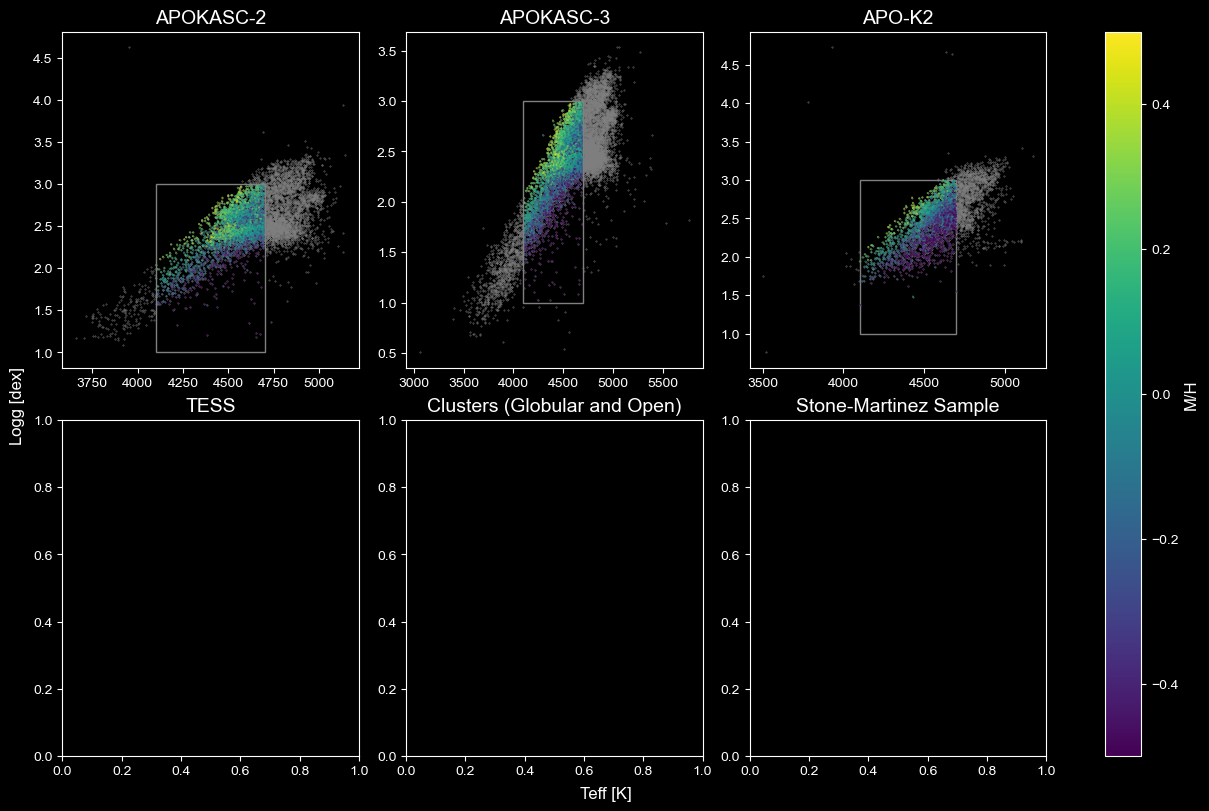

In [39]:
square_apokasc2 = plt.Rectangle((apokasc2_good_teffmin, apokasc2_good_loggmin), 
                                    apokasc2_good_teffmax - apokasc2_good_teffmin, apokasc2_good_loggmax - apokasc2_good_loggmin,
                                    edgecolor = 'grey', linestyle = '-', fill=False)
square_apokasc3 = plt.Rectangle((apokasc3_good_teffmin, apokasc3_good_loggmin), 
                                    apokasc3_good_teffmax - apokasc3_good_teffmin, apokasc3_good_loggmax - apokasc3_good_loggmin,
                                    edgecolor = 'grey', linestyle = '-', fill=False)
square_apok2 = plt.Rectangle((apok2_good_teffmin, apok2_good_loggmin), 
                                    apok2_good_teffmax - apok2_good_teffmin, apok2_good_loggmax - apok2_good_loggmin,
                                    edgecolor = 'grey', linestyle = '-', fill=False)
#square_tess = plt.Rectangle((tess_good_teffmin, tess_good_loggmin), 
#                                    tess_good_teffmax - tess_good_teffmin, tess_good_loggmax - tess_good_loggmin,
#                                    edgecolor = 'grey', linestyle = '-', fill=False)

vmin = -0.5
vmax = 0.5

fig = plt.figure(figsize= (12,8), layout='constrained')
sps = fig.subplots(2,3)
sps[0,0].scatter(data_apokasc2['teff'], data_apokasc2['logg'], color='gray', s=0.1)
sps[0,0].scatter(data_apokasc2_good['teff'], data_apokasc2_good['logg'], c=data_apokasc2_good['m_h_atm'], vmin=vmin, vmax=vmax, s=0.1)
sps[0,0].add_patch(square_apokasc2)
sps[0,0].set_title('APOKASC-2')
sps[0,1].scatter(data_apokasc3['teff'], data_apokasc3['logg'], color='gray', s=0.1)
sps[0,1].scatter(data_apokasc3_good['teff'], data_apokasc3_good['logg'], c=data_apokasc3_good['m_h_atm'],  vmin=vmin, vmax=vmax, s=0.1)
sps[0,1].add_patch(square_apokasc3)
sps[0,1].set_title('APOKASC-3')
sps[0,2].scatter(data_apok2['teff'], data_apok2['logg'], color='gray', s=0.1)
sps[0,2].add_patch(square_apok2)
im=sps[0,2].scatter(data_apok2_good['teff'], data_apok2_good['logg'], c=data_apok2_good['m_h_atm'],  vmin=vmin, vmax=vmax, s=0.1)
sps[0,2].set_title('APO-K2')
#sps[1,0].scatter(data_tess['teff'], data_tess['logg'], color='gray', s=0.1)
#sps[1,0].add_patch(square_tess)
#sps[1,0].scatter(data_tess_good['teff'], data_tess_good['logg'], c=data_tess_good['m_h_atm'], vmin=vmin, vmax=vmax, s=0.5)
sps[1,0].set_title('TESS')
sps[1,1].set_title('Clusters (Globular and Open)')
sps[1,2].set_title('Stone-Martinez Sample')
fig.colorbar(im, ax=sps, location='right', label='M/H')
fig.supylabel('Logg [dex]')
fig.supxlabel('Teff [K]')